In [1]:
# Importing initial packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
# from scipy.sparse import csr_matrix
import tqdm as tqdm
from sklearn.model_selection import ParameterGrid, KFold
import seaborn as sns

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, random_split

In [15]:
# Setting Hyperparameters

batch_size = 256
epochs = 5
lr = 0.005
accumulation_steps = 4
weight_decay = 1e-5
step_size = 10
gamma = 0.1
patience = 5

In [2]:
# Setting the device to GPU for parallelization
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Data Loading, Cleaning, and Preprocessing

### Data Loading

In [3]:
# In my project folder I added a data folder with both files (found in repo README) but did not push (gitignore) due to size

movies = pandas.read_csv('ml-25m/movies.csv')
ratings = pandas.read_csv('ml-25m/ratings_filled.csv')

### Data Anlayst

In [4]:
print(f"""The shape of movies is: {movies.shape}
The shape of rating is: {ratings.shape}""")

print(f"""The columns of movies is: {movies.columns.to_list()}
The columns of rating is: {ratings.columns.to_list()}

* Notice that both df's have a movieId column, which will be useful for merging""")

The shape of movies is: (<dask_expr.expr.Scalar: expr=ReadCSV(f3f7dc5).size() // 3, dtype=int64>, 3)
The shape of rating is: (<dask_expr.expr.Scalar: expr=ReadCSV(f3c592b).size() // 4, dtype=int64>, 4)
The columns of movies is: ['movieId', 'title', 'genres']
The columns of rating is: ['userId', 'movieId', 'rating', 'timestamp']

* Notice that both df's have a movieId column, which will be useful for merging


In [5]:
# Creating encoders and decoders for our movie ids
movie_ids = list(movies.movieId)
moviesid_to_title = dict(zip(movies.movieId,movies.title))    # Decoder
movietitle_to_id = {j:i for i,j in moviesid_to_title.items()} # Encoder

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


We'll inspect the distribution of the dataset, to get a better understanding of the spread of reviews

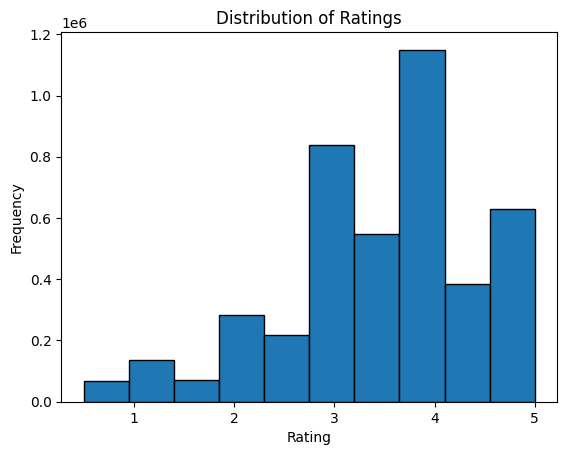

In [7]:
# Create the histogram
plt.hist(ratings['rating'], bins=10, edgecolor='black')

# Adding title and labels
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Display the plot
plt.show()

### Data Preprocessing

Loading Data with Dask and Creating Mappings

In [21]:

# Extract unique user and movie IDs to create mappings
unique_user_ids = ratings['userId'].unique().compute()
unique_movie_ids = ratings['movieId'].unique().compute()

# Create index mappings
user_id_mapping = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
movie_id_mapping = {movie_id: idx for idx, movie_id in enumerate(unique_movie_ids)}

# Initialize the user-rating matrix with zeros
num_users = len(unique_user_ids)
num_movies = len(unique_movie_ids)
user_rating_matrix = np.zeros((num_users, num_movies), dtype=np.float32)

# Function to process each chunk and update the user-rating matrix
def process_chunk(chunk, user_id_mapping, movie_id_mapping, user_rating_matrix):
    for row in chunk.itertuples(index=False):
        user_idx = user_id_mapping[row.userId]
        movie_idx = movie_id_mapping[row.movieId]
        user_rating_matrix[user_idx, movie_idx] = row.rating

# Read and process data in chunks
chunk_size = 100000  # You can adjust this based on your system's memory
chunks = pd.read_csv('ml-25m/ratings_filled.csv', chunksize=chunk_size)

for chunk in chunks:
    process_chunk(chunk, user_id_mapping, movie_id_mapping, user_rating_matrix)

In [22]:
# Convert this from a pandas df to numpy array
user_rating_matrix_np = user_rating_matrix 
print(f"Shape of the numpy matrix: {user_rating_matrix_np.shape}; represting {user_rating_matrix_np.shape[0]} users with {user_rating_matrix_np.shape[1]} movies.")

Shape of the numpy matrix: (28468, 35577); represting 28468 users with 35577 movies.


In [23]:
user_rating_matrix_tensor = torch.tensor(user_rating_matrix_np, dtype=torch.float32)

# Get the number of samples
num_samples = user_rating_matrix_tensor.shape[0]

# Define the split ratio
test_size = 0.2
split_index = int(num_samples * (1 - test_size))

# Shuffle the data
indices = torch.randperm(num_samples)

# Split the dataset
train_indices = indices[:split_index]
test_indices = indices[split_index:]

train_data = user_rating_matrix_tensor[train_indices]
test_data = user_rating_matrix_tensor[test_indices]

In [24]:
# Convert to PyTorch tensors
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

### Creating DataLoader

In [25]:
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.data = data.nonzero(as_tuple=True) # Get the indices of non-zero elements
        self.ratings = data[self.data]          # Using non-zero indiced to extract those ratings

    def __len__ (self):
        return len(self.data[0])

    def __getitem__ (self, idx):
        user = self.data[0][idx]
        item = self.data[1][idx]
        rating = self.ratings[idx]

        return user, item, rating

# Create training and testing datasets
train_dataset = RatingsDataset(train_data)
test_dataset = RatingsDataset(test_data)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Print dataset information
print(f"Batch size: {batch_size}")
print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in test_dataset: {len(test_dataset)}")

Batch size: 256
Number of samples in train_dataset: 3484292
Number of samples in test_dataset: 840198


## Model Development

### Defining Recommender model


In [26]:
class MFRecommender(nn.Module):
    def __init__(self, num_users, num_items, n_factors=50, dropout_rate=0.2):
        super(MFRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_factors)
        self.item_embedding = nn.Embedding(num_items, n_factors)
        
        self.fc1 = nn.Linear(n_factors, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(dropout_rate)  # Dropout to prevent overfitting

        # Embedding Initialization
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        x = user_emb * item_emb
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        return self.fc3(x)


### Initializing the Model


In [30]:
num_users, num_items = user_rating_matrix_np.shape


model = MFRecommender(num_users, num_items).to(device)

# Adjust the model initialization
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Add weight decay for regularization
scheduler = StepLR(optimizer, step_size, gamma)
criterion = nn.MSELoss().to(device)

# Use mixed precision training (if supported)
scaler = torch.cuda.amp.GradScaler()


### Defining traing loop function 

In [35]:
def training_loop(model, train_loader, optimizer, criterion, scaler, scheduler, epochs, patience=None):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    loss_dict = {'train_loss': []}

    for epoch in range(epochs):
        epoch_loss = 0
        # Initialize tqdm progress bar
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for user_batch, item_batch, rating_batch in train_loader:
                user_batch = user_batch.to(device)
                item_batch = item_batch.to(device)
                rating_batch = rating_batch.to(device)
                
                optimizer.zero_grad()
                
                with torch.cuda.amp.autocast():
                    output = model(user_batch, item_batch).squeeze()
                    loss = criterion(output, rating_batch)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                epoch_loss += loss.item()
                pbar.set_postfix({"loss": loss.item()})
                pbar.update(1)
        
        scheduler.step()
        avg_loss = epoch_loss / len(train_loader)
        loss_dict['train_loss'].append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

        if patience is not None:
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break
    
    return loss_dict

In [36]:
# Run Training Loop (the firs one)
loss_dict = training_loop(model, train_loader, optimizer, criterion, scaler, scheduler, epochs, patience=patience)

Epoch 1/5, Loss: 0.854516135466965
Epoch 2/5, Loss: 0.7457179148523333
Epoch 3/5, Loss: 0.7390900971861294
Epoch 4/5, Loss: 0.735290099299109
Epoch 5/5, Loss: 0.7317272157416302


### Model Evaluation

In [38]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():
        for user, item, rating in test_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            output = model(user, item).squeeze()
            loss = criterion(output, rating)
            total_loss += loss.item()
    
    average_loss = total_loss / len(test_loader)
    print(f'Test Loss: {average_loss}')
    return average_loss


In [39]:
# initial  the model
initial_test_loss = evaluate_model(model, test_loader, criterion)

Test Loss: 1.113952849871623


### Hyperparameter Tuning with Cross-Validation

In [ ]:
# Define the parameter grid
param_grid = {
    'n_factors': [20, 50, 100],
    'lr': [0.001, 0.005, 0.01],
    'batch_size': [128, 256, 512],
    'dropout_rate': [0.2, 0.5]
}

param_list = list(ParameterGrid(param_grid))

# Function for cross-validation
kf = KFold(n_splits=5)

def cross_validate_model(params):
    fold_losses = []
    for train_index, val_index in kf.split(dataset):
        train_data, val_data = dataset[train_index], dataset[val_index]
        train_loader = DataLoader(RatingsDataset(train_data), batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(RatingsDataset(val_data), batch_size=params['batch_size'], shuffle=False)
        
        model = MFRecommender(num_users, num_movies, n_factors=params['n_factors'], dropout_rate=params['dropout_rate']).to(device)
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size, gamma)
        criterion = nn.MSELoss().to(device)
        scaler = torch.cuda.amp.GradScaler()
        
        # Train the model
        training_loop(model, train_loader, optimizer, criterion, scaler, scheduler, epochs, patience)
        
        # Evaluate the model
        val_loss = evaluate_model(model, val_loader, criterion)
        fold_losses.append(val_loss)
    
    return np.mean(fold_losses)


# Run the cross-validation
results = []
best_loss = float('inf')
best_params = None
for params in param_list:
    print(f"Testing parameters: {params}")
    avg_val_loss = cross_validate_model(params)
    results.append({
        'n_factors': params['n_factors'],
        'lr': params['lr'],
        'batch_size': params['batch_size'],
        'dropout_rate': params['dropout_rate'],
        'val_loss': avg_val_loss
    })
    print(f"Average Validation Loss: {avg_val_loss}")
    
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_params = params

print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_loss}")

Testing parameters: {'batch_size': 128, 'dropout_rate': 0.2, 'lr': 0.001, 'n_factors': 20}
Epoch 1/5, Loss: 0.8580951008137395
Epoch 2/5, Loss: 0.6725316793093743
Epoch 3/5, Loss: 0.6443351633085177
Epoch 4/5, Loss: 0.6338467179816876
Epoch 5/5, Loss: 0.6289469833805837
Test Loss: 1.1673996841718726
Epoch 1/5, Loss: 0.8490801637580532
Epoch 2/5, Loss: 0.6693446288399593
Epoch 3/5, Loss: 0.6413824815458297
Epoch 4/5, Loss: 0.6306578145032101
Epoch 5/5, Loss: 0.6253379033020385
Test Loss: 1.1756998192342605
Epoch 1/5, Loss: 0.8519822481051648
Epoch 2/5, Loss: 0.6687772915292775
Epoch 3/5, Loss: 0.6398399519862301
Epoch 4/5, Loss: 0.6283799770093165
Epoch 5/5, Loss: 0.6228438742954646
Test Loss: 1.174799253308923
Epoch 1/5, Loss: 0.8456961483633261
Epoch 2/5, Loss: 0.671956247822824


#### Visualize Hyperparameter Tuning Results

In [ ]:
results_df = pd.DataFrame(results)

# Pivot table for heatmap
heatmap_data = results_df.pivot_table(index='n_factors', columns='lr', values='val_loss')
sns.heatmap(heatmap_data, annot=True, cmap="viridis")
plt.title('Validation Loss for Different Hyperparameter Combinations')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Factors')
plt.show()

#### Train Final Model with Best Hyperparameters

In [ ]:
# Train the final model with the best hyperparameters
final_model = MFRecommender(num_users, num_movies, n_factors=best_params['n_factors'], dropout_rate=best_params['dropout_rate']).to(device)
final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'], weight_decay=weight_decay)
final_scheduler = StepLR(final_optimizer, step_size, gamma)
final_criterion = nn.MSELoss().to(device)
final_scaler = torch.cuda.amp.GradScaler()

# Use the entire dataset for training
final_train_loader = DataLoader(RatingsDataset(dataset), batch_size=best_params['batch_size'], shuffle=True)

# Train the final model
final_loss_dict = training_loop(final_model, final_train_loader, final_optimizer, final_criterion, final_scaler, final_scheduler, epochs, patience)


In [ ]:
# Evaluate Final Model
final_test_loss = evaluate_model(final_model, test_loader, final_criterion)
print(f'Final Test Loss: {final_test_loss}')



In [ ]:
# Visualize the initial and final test loss
performance_data = {
    'Model': ['Initial Model', 'Final Model'],
    'Test Loss': [initial_test_loss, final_test_loss]
}

performance_df = pd.DataFrame(performance_data)

sns.barplot(data=performance_df, x='Model', y='Test Loss', palette='viridis')
plt.title('Comparison of Initial and Final Model Test Loss')
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.show()

# Visualize the training loss over epochs for both models
initial_loss_df = pd.DataFrame(list(initial_loss_dict.items()), columns=['Epoch', 'Loss'])
final_loss_df = pd.DataFrame(list(final_loss_dict.items()), columns=['Epoch', 'Loss'])

plt.plot(initial_loss_df['Epoch'], initial_loss_df['Loss'], label='Initial Model', marker='o')
plt.plot(final_loss_df['Epoch'], final_loss_df['Loss'], label='Final Model', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()
